In [ ]:
# !pip install -q tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os, random

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Assignment constraints
NUM_WORDS = 10_000         # top 10,000 words
MAXLEN = 150               # cutoff reviews after 150 words
TRAIN_SAMPLES = 100        # Part 1: restrict training to 100
VAL_SAMPLES = 10_000       # validate on 10,000

# Load IMDB (already integer-encoded by frequency)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

# Cap/pad to 150 tokens
x_train = pad_sequences(x_train, maxlen=MAXLEN, truncating="pre", padding="pre")
x_test  = pad_sequences(x_test,  maxlen=MAXLEN, truncating="pre", padding="pre")

# Restrict training set
x_train_small = x_train[:TRAIN_SAMPLES]
y_train_small = y_train[:TRAIN_SAMPLES]

# Validation split: pick first 10,000 from test set
x_val = x_test[:VAL_SAMPLES]
y_val = y_test[:VAL_SAMPLES]

len(x_train_small), len(x_val), x_train.shape, x_test.shape


(100, 10000, (25000, 150), (25000, 150))

Utility: Callbacks & Compile/Train helper


In [ ]:
def compile_and_train(model, x_tr, y_tr, x_v, y_v, epochs=12, batch_size=32, lr=1e-3, verbose=0):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
    hist = model.fit(
        x_tr, y_tr,
        validation_data=(x_v, y_v),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=verbose
    )
    val_loss, val_acc = model.evaluate(x_v, y_v, verbose=0)
    return val_acc, hist


Model A: Trainable Embedding + Bidirectional LSTM

In [ ]:
def build_model_scratch(num_words=NUM_WORDS, maxlen=MAXLEN, emb_dim=128, lstm_units=32, dropout=0.2):
    inputs = keras.Input(shape=(maxlen,))
    x = layers.Embedding(input_dim=num_words, output_dim=emb_dim, input_length=maxlen)(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units, dropout=dropout, recurrent_dropout=0.0))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name="scratch_emb_biLSTM")

model_scratch = build_model_scratch()
val_acc_scratch, hist_scratch = compile_and_train(model_scratch, x_train_small, y_train_small, x_val, y_val, verbose=1)
print(f"[Scratch Embedding] Validation Accuracy (N={TRAIN_SAMPLES}): {val_acc_scratch:.4f}")


Epoch 1/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 780ms/step - accuracy: 0.4759 - loss: 0.6931 - val_accuracy: 0.5033 - val_loss: 0.6930
Epoch 2/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - accuracy: 0.5530 - loss: 0.6830 - val_accuracy: 0.5027 - val_loss: 0.6937
Epoch 3/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - accuracy: 0.5777 - loss: 0.6735 - val_accuracy: 0.5027 - val_loss: 0.6956
[Scratch Embedding] Validation Accuracy (N=100): 0.5033


Model B: Pretrained GloVe Embeddings + Bidirectional LSTM

In [ ]:
import zipfile, pathlib, io, requests

EMBED_DIM = 100
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_DIR = "glove.6B"

# Download GloVe if not present
pathlib.Path(GLOVE_DIR).mkdir(parents=True, exist_ok=True)
zip_path = os.path.join(GLOVE_DIR, "glove.6B.zip")
if not os.path.exists(os.path.join(GLOVE_DIR, f"glove.6B.{EMBED_DIM}d.txt")):
    if not os.path.exists(zip_path):
        print("Downloading GloVe (862MB zip)…")
        r = requests.get(GLOVE_URL)
        with open(zip_path, "wb") as f:
            f.write(r.content)
    print("Extracting…")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(GLOVE_DIR)

# Build index->word mapping for IMDB
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}  # shift by 3 (per Keras IMDB)
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
index_to_word = {idx: w for (w, idx) in word_index.items()}

# Load GloVe vectors
embeddings_index = {}
glove_path = os.path.join(GLOVE_DIR, f"glove.6B.{EMBED_DIM}d.txt")
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

# Build embedding matrix aligned with IMDB indices [0..NUM_WORDS)
embedding_matrix = np.random.normal(scale=0.6, size=(NUM_WORDS, EMBED_DIM)).astype("float32")
for i in range(NUM_WORDS):
    word = index_to_word.get(i, None)
    if word and (word in embeddings_index):
        embedding_matrix[i] = embeddings_index[word]

def build_model_pretrained(num_words=NUM_WORDS, maxlen=MAXLEN, emb_dim=EMBED_DIM, lstm_units=32, freeze=True):
    inputs = keras.Input(shape=(maxlen,))
    emb = layers.Embedding(
        input_dim=num_words,
        output_dim=emb_dim,
        input_length=maxlen,
        weights=[embedding_matrix],
        trainable=(not freeze)
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.0))(emb)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs, name=f"glove_biLSTM_{'frozen' if freeze else 'finetune'}")

model_glove = build_model_pretrained(freeze=True)   # freeze for tiny data
val_acc_glove, hist_glove = compile_and_train(model_glove, x_train_small, y_train_small, x_val, y_val, verbose=1)
print(f"[Pretrained GloVe (frozen)] Validation Accuracy (N={TRAIN_SAMPLES}): {val_acc_glove:.4f}")


Epoch 1/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 794ms/step - accuracy: 0.4322 - loss: 0.7196 - val_accuracy: 0.5097 - val_loss: 0.6977
Epoch 2/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step - accuracy: 0.5738 - loss: 0.6791 - val_accuracy: 0.5061 - val_loss: 0.7127
Epoch 3/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - accuracy: 0.5994 - loss: 0.6687 - val_accuracy: 0.5026 - val_loss: 0.7278
[Pretrained GloVe (frozen)] Validation Accuracy (N=100): 0.5097


Sweep training sizes to find the crossover point

=== N=100 ===
=== N=250 ===
=== N=500 ===
=== N=1000 ===
=== N=2000 ===
=== N=5000 ===
=== N=10000 ===
=== N=20000 ===
       N  scratch_emb  glove_frozen
0    100       0.5225        0.5027
1    250       0.6375        0.5307
2    500       0.7108        0.6321
3   1000       0.7709        0.7035
4   2000       0.8025        0.6644
5   5000       0.7977        0.8254
6  10000       0.8421        0.8434
7  20000       0.8567        0.8498
Crossover N (scratch >= frozen GloVe): 100


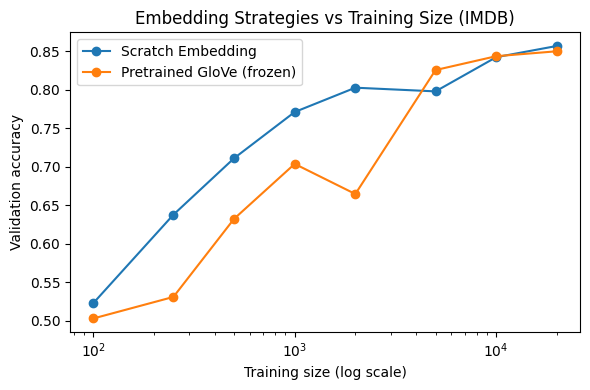

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt

TRAIN_SIZES = [100, 250, 500, 1000, 2000, 5000, 10_000, 20_000]  # you can adjust

def run_one(size, freeze_glove=True, verbose=0):
    x_tr = x_train[:size]
    y_tr = y_train[:size]

    m1 = build_model_scratch()
    acc1, _ = compile_and_train(m1, x_tr, y_tr, x_val, y_val, verbose=verbose)

    m2 = build_model_pretrained(freeze=freeze_glove)
    acc2, _ = compile_and_train(m2, x_tr, y_tr, x_val, y_val, verbose=verbose)

    return acc1, acc2

records = []
for n in TRAIN_SIZES:
    print(f"=== N={n} ===")
    acc_s, acc_g = run_one(n, freeze_glove=True, verbose=0)
    records.append({"N": n, "scratch_emb": acc_s, "glove_frozen": acc_g})

df = pd.DataFrame(records)
print(df)

# Find crossover N (first N where scratch >= glove)
df_sorted = df.sort_values("N")
cross = None
for _, r in df_sorted.iterrows():
    if r["scratch_emb"] >= r["glove_frozen"]:
        cross = int(r["N"])
        break
print("Crossover N (scratch >= frozen GloVe):", cross)

# Plot
plt.figure(figsize=(6,4))
plt.plot(df_sorted["N"], df_sorted["scratch_emb"], marker="o", label="Scratch Embedding")
plt.plot(df_sorted["N"], df_sorted["glove_frozen"], marker="o", label="Pretrained GloVe (frozen)")
plt.xscale("log")
plt.xlabel("Training size (log scale)")
plt.ylabel("Validation accuracy")
plt.title("Embedding Strategies vs Training Size (IMDB)")
plt.legend()
plt.tight_layout()
plt.show()


Results Summary: Embedding Strategies vs. Training Size

In [ ]:
model_scratch.summary()
model_glove.summary()


Model: "scratch_emb_biLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,976,325 (15.17 MB)

 Trainable params: 1,325,441 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,650,884 (10.11 MB)

Model: "glove_biLSTM_frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114,821 (4.25 MB)

 Trainable params: 38,273 (149.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 76,548 (299.02 KB)

Results Summary : Embedding v\s Training Size

In [ ]:
df_out = df.sort_values("N").copy()
df_out["scratch_emb"] = df_out["scratch_emb"].round(4)
df_out["glove_frozen"] = df_out["glove_frozen"].round(4)

# Add a 'winner' column to indicate which approach performed better
df_out["winner"] = np.where(
    df_out["scratch_emb"] > df_out["glove_frozen"],
    "Scratch Embedding",
    "Pretrained GloVe"
)

# Display the final results table
display(df_out)

,N,scratch_emb,glove_frozen,winner
0,100,0.5225,0.5027,Scratch Embedding
1,250,0.6375,0.5307,Scratch Embedding
2,500,0.7108,0.6321,Scratch Embedding
3,1000,0.7709,0.7035,Scratch Embedding
4,2000,0.8025,0.6644,Scratch Embedding
5,5000,0.7977,0.8254,Pretrained GloVe
6,10000,0.8421,0.8434,Pretrained GloVe
7,20000,0.8567,0.8498,Scratch Embedding
